# Classical time-series Forecasting Models - Traffic & Electricity benchmarks

- **Master Thesis**: *'Time Series Forecasting using Transformers'*
- **Author**: Andrés Carrillo López
- **Thesis Tutor**: Pablo Martínez Olmos

**Goal of this notebook**: Once retrieved the Electricity and Traffic benchmark datasets in aggregated format, a series of classical forecasting models (such as *ARIMA*, SARIMAX and *ETS*) will be tested on the available data and their performance will be evaluated, to serve as benchmark models for later comparison on deep learning and transformer models analyzed in this thesis.

## Setup

In [ ]:
!pip install statsmodels --upgrade
!pip install pmdarima

In [1]:
# Generic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(16, 6))

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

https://towardsdatascience.com/lets-forecast-your-time-series-using-classical-approaches-f84eb982212c

https://www.statsmodels.org/stable/examples/index.html#time-series-analysis

In [2]:
# Defining time indexes.
last_week = -168 # last 168 hours (7 days) of training data. Plotted data starts here
next_day = 24
next_4_days = 24*4
next_week = 24* 7

In [3]:
# Creating a custom function for forecast predictions
def plot_electr_forecast(train_data, test_data, pred_data, forecast_t, forecast_method):
    """
    train_data: ndarray containing the data used for fitting the forecast model.
    test_data: ndarray containing the reserved test data.
    pred_data: ndarray containing the forecast for <forecast_t> hours.
    forecast_t: int with the number of hours of forecast.
    forecast_method: str with model name (for labelling plot).
    """
    plt.plot(train_data[last_week:], label='Past data')
    plt.plot([None for i in train_data[last_week:]] + [x for x in test_data[:forecast_t]], label='True')
    plt.plot([None for i in train_data[last_week:]] + [x for x in pred_data[:forecast_t]], label='Forecast')
    plt.title(f"Electricity consumption {str(forecast_t)} hr(s). forecast - {forecast_method} method.")
    plt.ylabel("Electricity consumption (KWh)")
    plt.xlabel("Time (hours)")
    plt.legend()
    plt.show();

# Electricity Dataset

## Dataset Load and Preparation

In [5]:
# Note: my Google Drive has been synced with this colab notebook previously
%cd "drive/MyDrive/Máster Big Data (2020-2021)/TFM/Code Notebooks"

/content/drive/MyDrive/Máster Big Data (2020-2021)/TFM/Code Notebooks


We will first load the raw dataset and then add a 'date' column, as well as considering that each column is a different time series:

In [6]:
#electr_df = pd.read_csv("data/aggr_data/electricity.txt", header=None)
#electr_df['date'] = pd.date_range(start='1/1/2012', periods=electr_df.shape[0], freq="H")
# reorder columns
#cols = electr_df.columns.tolist() 
#cols = cols[-1:] + cols[:-1]
#electr_df = electr_df[cols]
#electr_df.to_csv("data/aggr_data/electr_proc_data.csv") #to later use with library
# showing sample
electr_df = pd.read_csv("data/aggr_data/electr_proc_data.csv", index_col=0)
electr_df

,date,0,1,2,3,4,5,6,7,8,...,311,312,313,314,315,316,317,318,319,320
0,2012-01-01 00:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,2012-01-01 01:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,2012-01-01 02:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,2012-01-01 03:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,2012-01-01 04:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2014-12-31 19:00:00,11.0,116.0,8.0,844.0,384.0,1590.0,51.0,1412.0,407.0,...,1897.0,1589.0,166500.0,9917.0,10412.0,324.0,21.0,1870.0,162.0,2773.0
26300,2014-12-31 20:00:00,11.0,103.0,8.0,749.0,371.0,1366.0,47.0,1265.0,369.0,...,1374.0,1336.0,158800.0,6812.0,8956.0,302.0,20.0,1506.0,438.0,2755.0
26301,2014-12-31 21:00:00,12.0,93.0,8.0,650.0,346.0,1282.0,48.0,1079.0,308.0,...,938.0,1311.0,154300.0,6602.0,5910.0,302.0,18.0,1864.0,621.0,2650.0
26302,2014-12-31 22:00:00,10.0,92.0,8.0,646.0,349.0,1261.0,48.0,1009.0,288.0,...,833.0,1227.0,141900.0,6546.0,5502.0,259.0,33.0,2623.0,783.0,2719.0


Now, for performance evaluation, we will split our series in a train set consisting of the first 70% hours, and the test set using the following 30%.

In [7]:
data = electr_df["320"].values # We will pick this particular series for the experiment

train_size = int(len(data) * 0.7) # 70% of the data (past)
train, test = data[0:train_size], data[train_size:len(data)]
print('Number of observations: %d (hours)' % (len(data)))
print('Num. of Training Observations: %d (hours)' % (len(train)))
print('Num. of Test Observations: %d (hours)' % (len(test)))

Number of observations: 26304 (hours)
Num. of Training Observations: 18412 (hours)
Num. of Test Observations: 7892 (hours)


## ARIMA

In [4]:
import pmdarima as pm

In [12]:
len(train[:-365*24]) # last year for this case (comp. expensive)

9652

https://robjhyndman.com/hyndsight/seasonal-periods/

In [ ]:
#Note: our hourly data has the 'multiple-seasonality' problem that ARIMA/SARIMA models cannot deal with

In [8]:
model = pm.auto_arima(train[:-365*24], m=24, trace=True,random_state=42) #hourly freq.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=30.90 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=126883.869, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=125086.200, Time=11.75 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=125750.863, Time=10.73 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=126881.870, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=126826.876, Time=0.25 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=124446.252, Time=42.62 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=107.61 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=24.72 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=124559.564, Time=39.57 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=124418.655, Time=59.47 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=125076.714, Time=15.74 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=138.04 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=28.94 sec
 ARIMA(3,1,0)

In [12]:
# save model to disk:
import joblib
joblib.dump(model, "arima_model.pkl", compress=3)
#model = joblib.load("arima_model.pkl")

['arima_model.pkl']

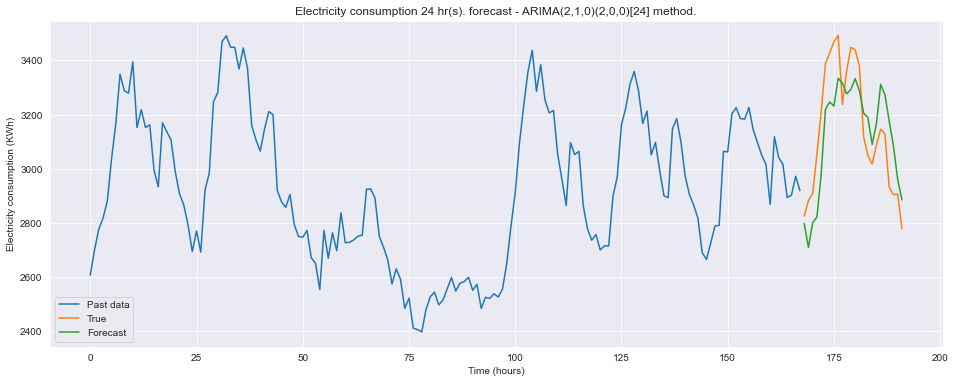

In [13]:
forecast_1day_ARIMA = model.predict(next_day)
plot_electr_forecast(train, test, forecast_1day_ARIMA, next_day, "ARIMA(2,1,0)(2,0,0)[24]")

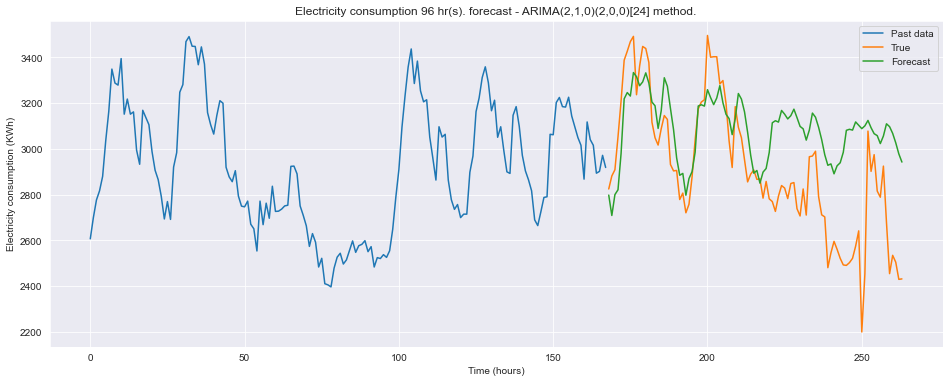

In [14]:
forecast_4day_ARIMA = model.predict(next_4_days) 
plot_electr_forecast(train, test, fcast, next_4_days, "ARIMA(2,1,0)(2,0,0)[24]")

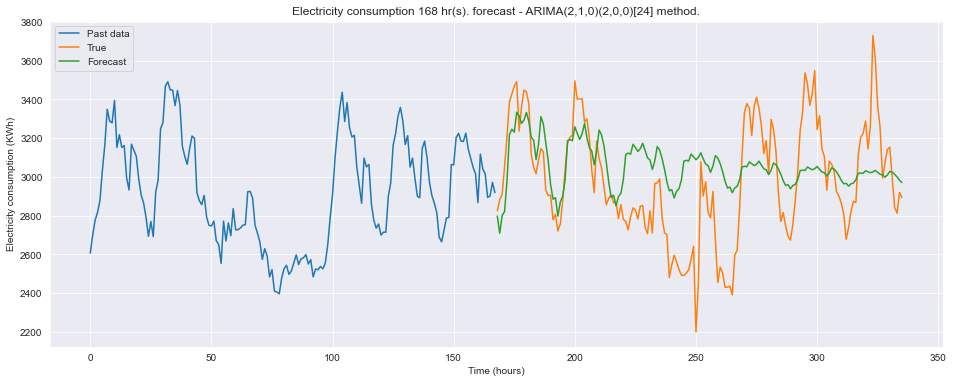

In [17]:
forecast_1week_ARIMA = model.predict(next_week) 
plot_electr_forecast(train, test, forecast_1week_ARIMA, next_week, "ARIMA(2,1,0)(2,0,0)[24]")

In [ ]:
# TODO: compute MSE / MAE for 1 day, 4 days and 1 week forecasts using windows (average results)

In [21]:
true = test[:168] # (next week , i.e. first 168 hours from train data last point)

rmse = np.sqrt(mean_squared_error(true, forecast_1week_ARIMA) )
mae = mean_absolute_error(true, forecast_1week_ARIMA)

print("1 week forecast - RMSE: {:.2f}. MAE: {:.2f}.".format(rmse, mae))

1 week forecast - RMSE: 278.20. MAE: 223.40.


## Simple Exponential Smoothing (SES)

In [22]:
from statsmodels.tsa.api import SimpleExpSmoothing

/Users/andrescarrillo/opt/anaconda3/envs/eB2-Data/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


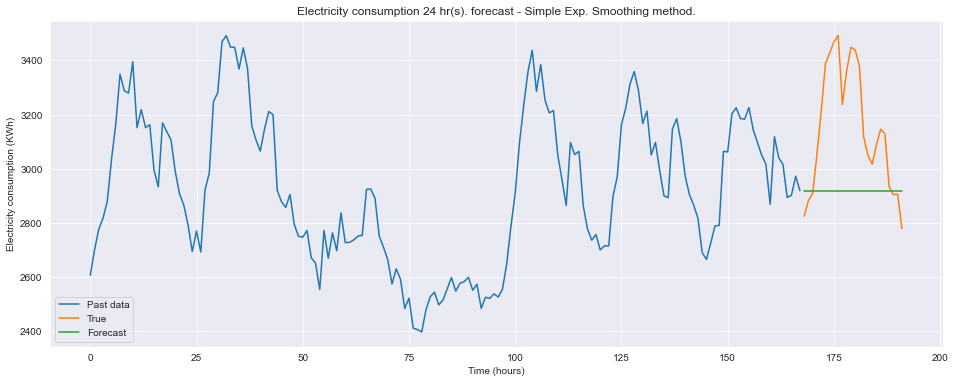

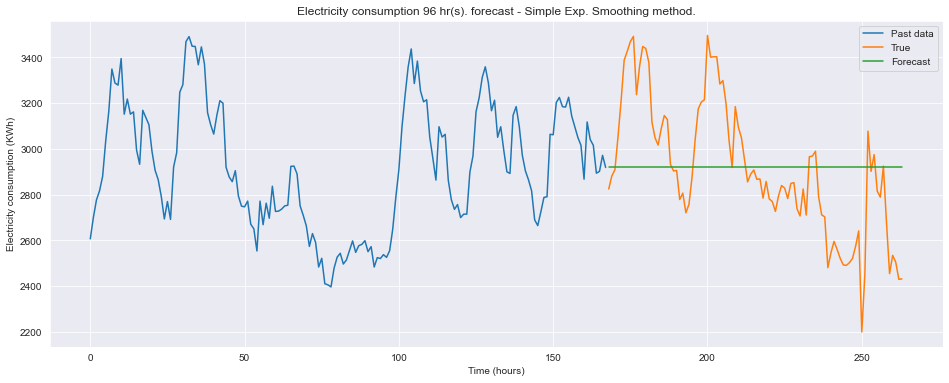

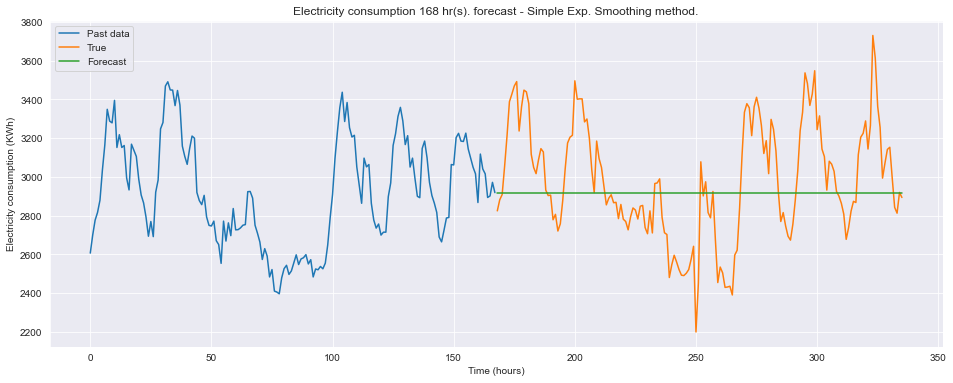

In [23]:
simple_ES = SimpleExpSmoothing(train, initialization_method="estimated").fit()

# Generating a 1-day forecast
forecast_1day_SES = simple_ES.forecast(next_day)
plot_electr_forecast(train, test, forecast_1day_SES, next_day, "Simple Exp. Smoothing")
# Generating a 4-day forecast
forecast_4day_SES = simple_ES.forecast(next_4_days)
plot_electr_forecast(train, test, forecast_4day_SES, next_4_days, "Simple Exp. Smoothing")
# Generating a 1-week forecast
forecast_1week_SES = simple_ES.forecast(next_week)
plot_electr_forecast(train, test, forecast_1week_SES, next_week, "Simple Exp. Smoothing")

In [24]:
rmse = np.sqrt(mean_squared_error(true, forecast_1week_SES))
mae = mean_absolute_error(true, forecast_1week_SES)

print("1 week forecast - RMSE: {:.2f}. MAE: {:.2f}.".format(rmse, mae))

1 week forecast - RMSE: 303.68. MAE: 246.01.


## Holt-Winters Exponential Smoothing

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Lets estimate the best model for our training data:
holtwinter_ES = ExponentialSmoothing((train+1), trend='add',seasonal="add", 
                            seasonal_periods=24, #24 as for hourly data
                            damped_trend=True, use_boxcox=True,
                            initialization_method='heuristic').fit()

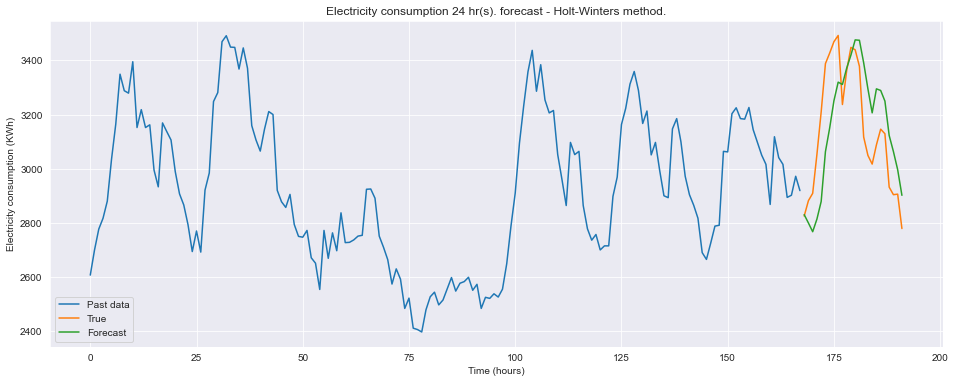

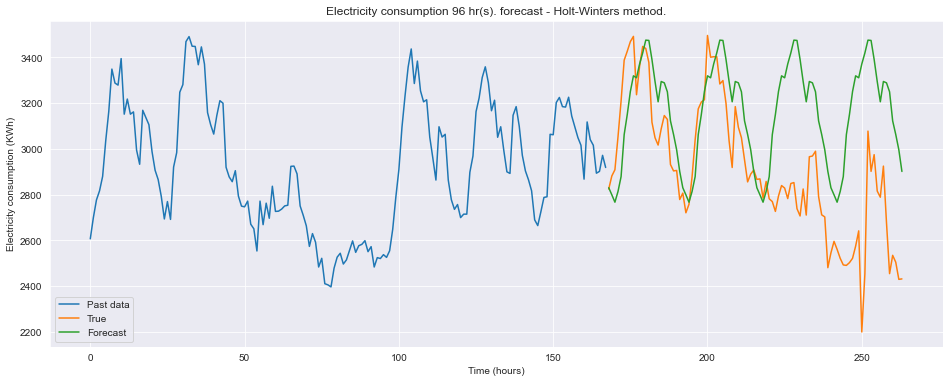

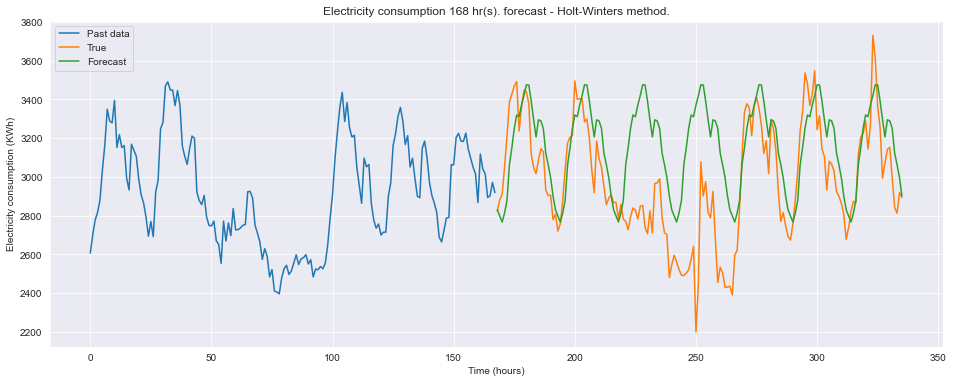

In [28]:
# Generating a 1-day forecast
forecast_1day_HWES = holtwinter_ES.forecast(next_day)
plot_electr_forecast(train, test, forecast_1day_HWES, next_day, "Holt-Winters")
# Generating a 4-day forecast
forecast_4day_HWES = holtwinter_ES.forecast(next_4_days)
plot_electr_forecast(train, test, forecast_4day_HWES, next_4_days, "Holt-Winters")
# Generating a 1-week forecast
forecast_1week_HWES = holtwinter_ES.forecast(next_week)
plot_electr_forecast(train, test, forecast_1week_HWES, next_week, "Holt-Winters")

In [29]:
rmse = np.sqrt(mean_squared_error(true, forecast_1week_HWES))
mae = mean_absolute_error(true, forecast_1week_HWES)

print("1 week forecast - RMSE: {:.2f}. MAE: {:.2f}.".format(rmse, mae))

1 week forecast - RMSE: 309.90. MAE: 233.72.
